In [188]:
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import sys
import gin
import pickle
from tensorflow.keras.backend import image_data_format
from sparse_causal_model_learner.toy_datasets.progressbar import 
from math import ceil
import matplotlib
%matplotlib inline

In [190]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [191]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [33]:
gin.enter_interactive_mode()

In [126]:
gin.bind_parameter('progressbar_image.colors', ['lime'])
gin.bind_parameter('progressbar_image.max_values', [30])
gin.bind_parameter('progressbar_image.width', 10)

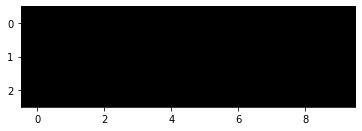

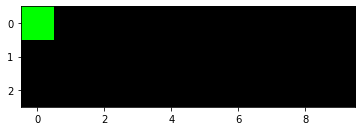

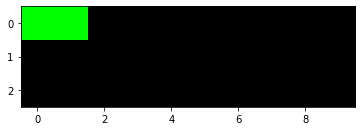

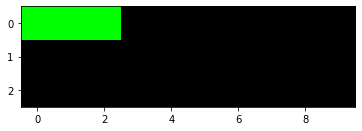

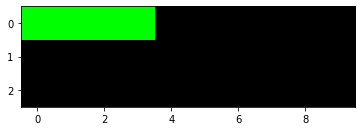

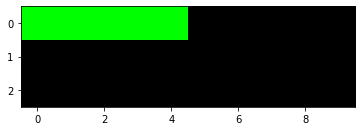

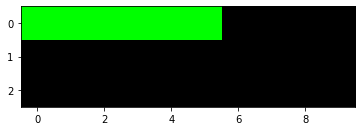

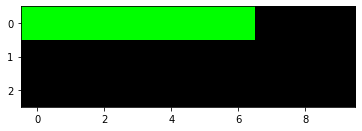

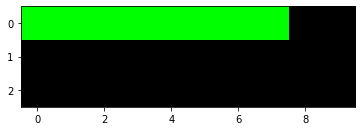

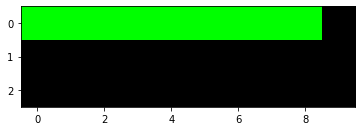

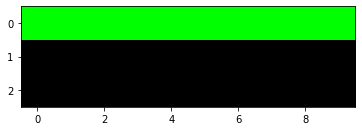

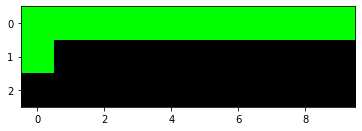

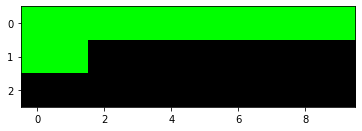

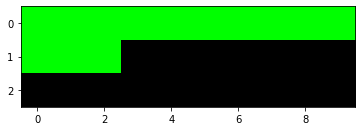

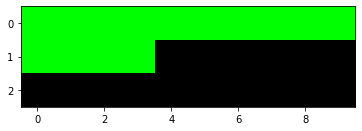

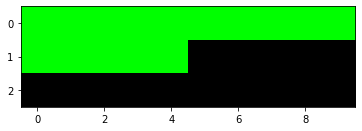

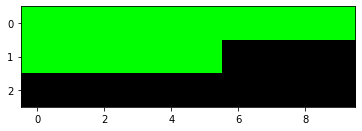

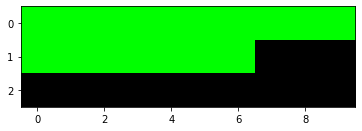

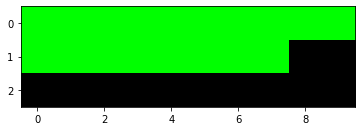

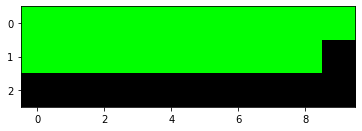

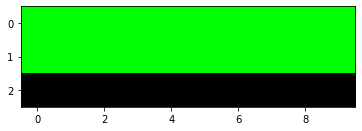

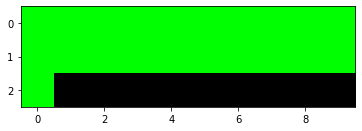

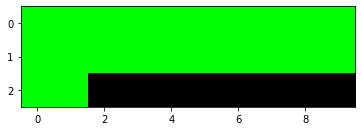

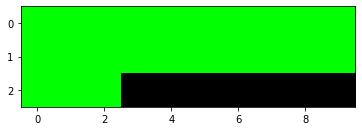

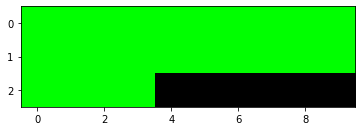

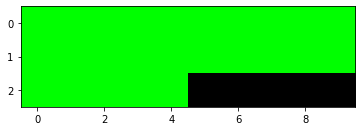

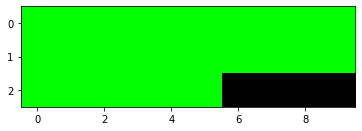

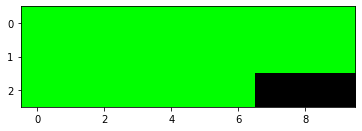

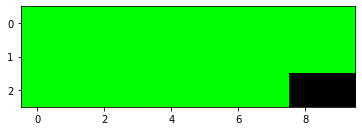

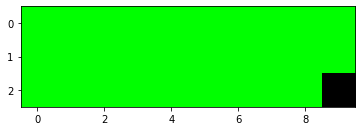

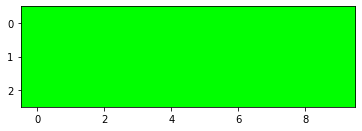

In [127]:
for i in range(30 + 1):
    pb = progressbar_image([i])
    plt.imshow(pb)
    plt.show()

In [49]:
X = np.array([progressbar_image([i]) for i in range(30 + 1)])

In [52]:
h, w, c = X.shape[1:]

In [55]:
ae = tf.keras.Sequential([
    tf.keras.Input(shape=(h, w, c)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation=None),
    tf.keras.layers.Dense(h * w * c, activation='sigmoid'),
    tf.keras.layers.Reshape((h, w, c))
])

In [57]:
ae.compile('adam', 'mse')

In [94]:
history = ae.fit(X, X, epochs=50000, verbose=0)

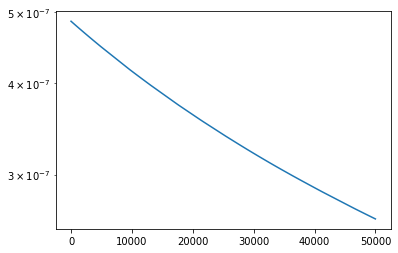

In [95]:
plt.plot(history.history['loss'])
plt.yscale('log')

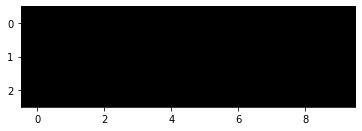

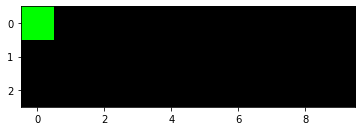

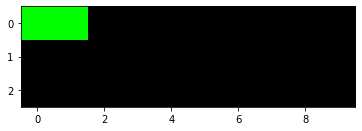

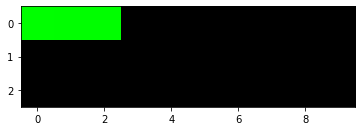

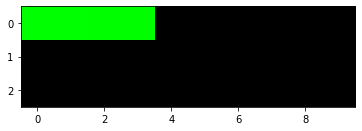

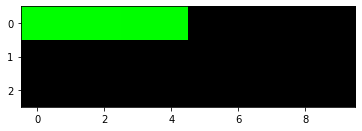

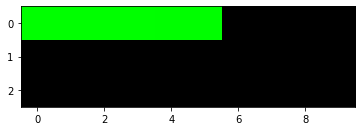

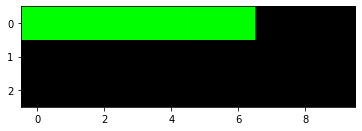

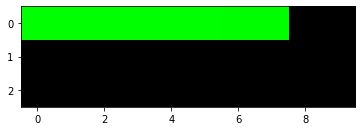

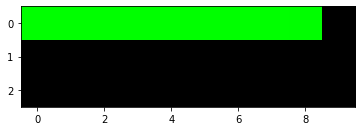

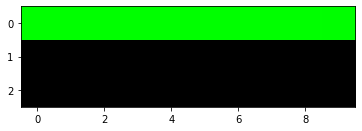

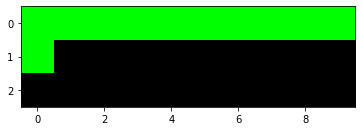

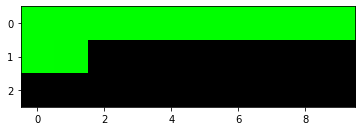

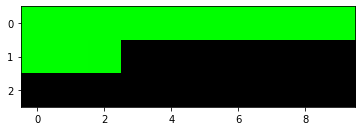

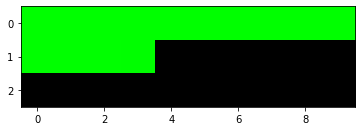

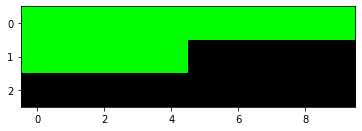

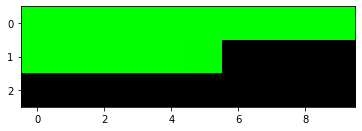

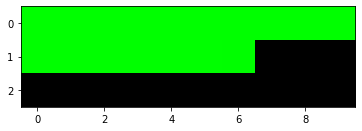

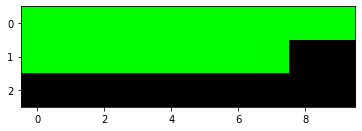

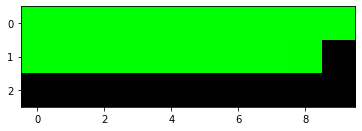

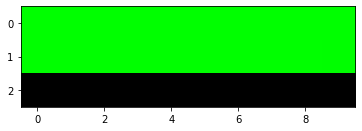

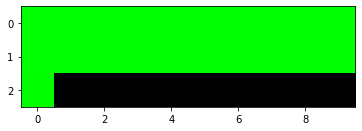

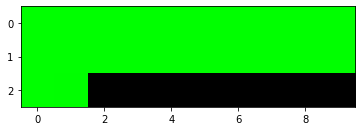

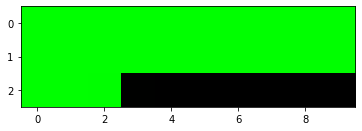

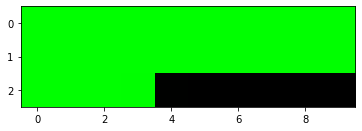

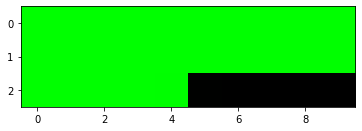

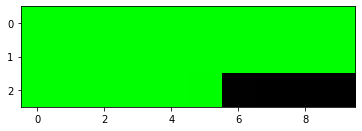

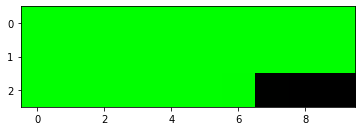

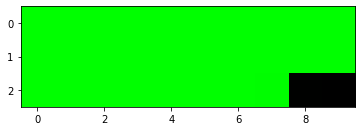

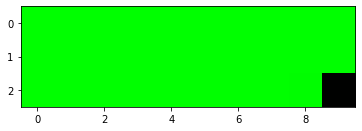

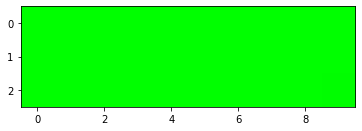

In [96]:
for i in range(len(X)):
    plt.imshow(ae.predict(X[i:i+1])[0])
    plt.show()

In [98]:
ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 90)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 91        
_________________________________________________________________
dense_1 (Dense)              (None, 90)                180       
_________________________________________________________________
reshape (Reshape)            (None, 3, 10, 3)          0         
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [102]:
hid = tf.keras.models.Model(inputs=ae.inputs, outputs=ae.layers[1].output)

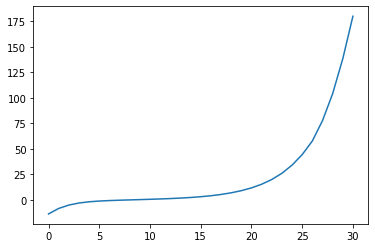

In [105]:
plt.plot(hid.predict(X).reshape(-1))

Works perfectly

# 2 progress bars, 1 hidden dim

In [128]:
gin.bind_parameter('progressbar_image.colors', ['lime', 'blue'])
gin.bind_parameter('progressbar_image.max_values', [30, 10])
gin.bind_parameter('progressbar_image.width', 10)

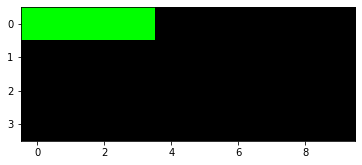

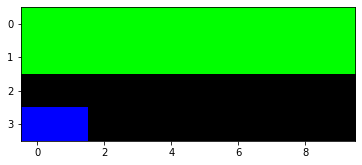

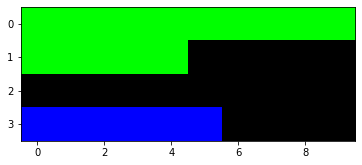

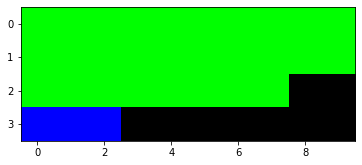

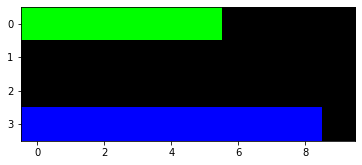

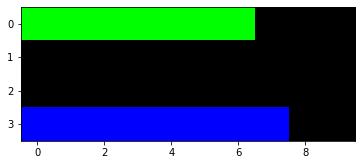

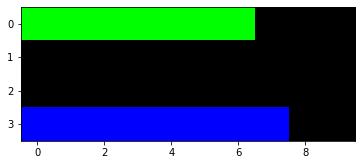

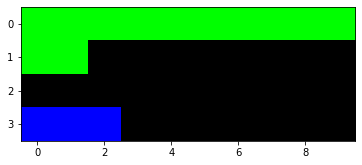

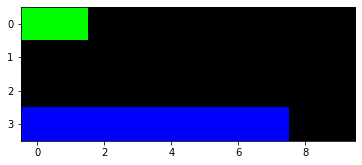

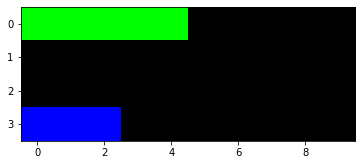

In [130]:
for _ in range(10):
    i = np.random.choice(30 + 1)
    j = np.random.choice(10 + 1)
    pb = progressbar_image([i, j])
    plt.imshow(pb)
    plt.show()

In [139]:
X = np.array([progressbar_image([i, j]) for i in range(31) for j in range(11)])
h, w, c = X.shape[1:]

In [141]:
ae = tf.keras.Sequential([
    tf.keras.Input(shape=(h, w, c)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation=None),
    tf.keras.layers.Dense(h * w * c, activation='sigmoid'),
    tf.keras.layers.Reshape((h, w, c))
])

In [142]:
ae.compile('adam', 'mse')

In [ ]:
history = ae.fit(X, X, epochs=500000, verbose=0)

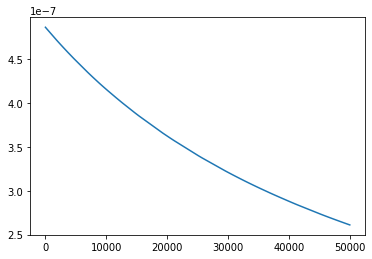

In [148]:
plt.plot(history.history['loss'])

In [172]:
ae.evaluate(X, X)

0.015152152269925714

In [156]:
hid = tf.keras.models.Model(inputs=ae.inputs, outputs=ae.layers[1].output)

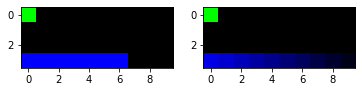

In [171]:
idx = np.random.choice(len(X))

img = X[idx].reshape(h, w, c)
pred = ae.predict(X[idx:idx+1])[0].reshape(h, w, c)
hidden = hid.predict(X[idx:idx+1])[0].reshape(1)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.show()

In [177]:
import seaborn as sns

<AxesSubplot:>

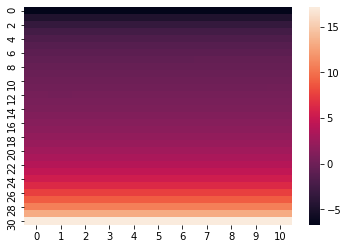

In [180]:
sns.heatmap(hid.predict(X).reshape(31, 11))

# 2 progress bars, 2 hidden dims

In [182]:
gin.bind_parameter('progressbar_image.colors', ['lime', 'blue'])
gin.bind_parameter('progressbar_image.max_values', [30, 10])
gin.bind_parameter('progressbar_image.width', 10)

In [183]:
X = np.array([progressbar_image([i, j]) for i in range(31) for j in range(11)])
h, w, c = X.shape[1:]

In [184]:
ae = tf.keras.Sequential([
    tf.keras.Input(shape=(h, w, c)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=None),
    tf.keras.layers.Dense(h * w * c, activation='sigmoid'),
    tf.keras.layers.Reshape((h, w, c))
])

In [185]:
ae.compile('adam', 'mse')

In [199]:
history = ae.fit(X, X, epochs=50000, verbose=0)

<IPython.core.display.Javascript object>

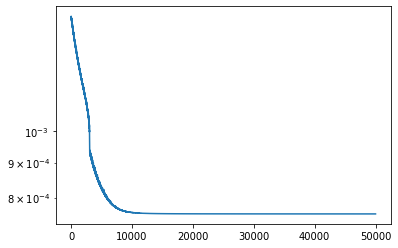

In [203]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [204]:
ae.evaluate(X, X)

0.0007576419686136597

In [205]:
hid = tf.keras.models.Model(inputs=ae.inputs, outputs=ae.layers[1].output)

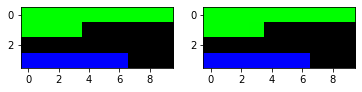

In [223]:
idx = np.random.choice(len(X))

img = X[idx].reshape(h, w, c)
pred = ae.predict(X[idx:idx+1])[0].reshape(h, w, c)
hidden = hid.predict(X[idx:idx+1])[0].reshape(2)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.show()

<AxesSubplot:>

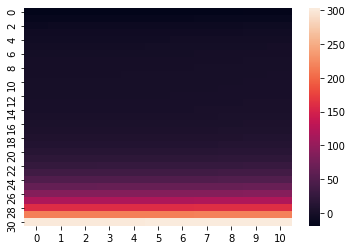

In [227]:
sns.heatmap(hid.predict(X).reshape(31, 11, 2)[:, :, 0])

<AxesSubplot:>

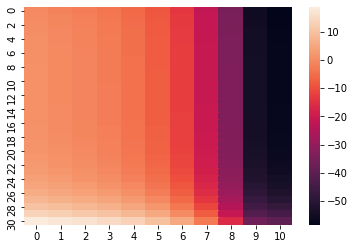

In [228]:
sns.heatmap(hid.predict(X).reshape(31, 11, 2)[:, :, 1])

# Random object position dataset

In [497]:
@gin.configurable
def image_object_positions(h, w, positions,
                           colors):
    """Generate an image with objects at given positions.
    
    Args:
        h: height of the resulting image
        w: width of the resulting image
        positions: list of (x, y) coordinates for object positions
        colors: list of colors for objects, same length as positions
        n_objects: 
    
    """
    assert len(positions) == len(colors)
    
    result = np.zeros((h, w, 3))
    colors_rgb = [matplotlib.colors.to_rgb(c) for c in colors]
    
    for p, c in zip(positions, colors_rgb):
        if 0 <= p[0] < h and 0 <= p[1] < w:
            result[p[0], p[1]] = c
    
    return result

In [498]:
@gin.configurable
def random_coordinates(h, w):
    """Get random coordinates inside the grid."""
    return (np.random.choice(h), np.random.choice(w))

@gin.configurable
def random_coordinates_n(n):
    """Get many random coordinates."""
    return [random_coordinates() for _ in range(n)]

In [499]:
gin.bind_parameter('image_object_positions.h', 16)
gin.bind_parameter('image_object_positions.w', 8)
gin.bind_parameter('image_object_positions.colors', ['red', 'red',
                                   'green', 'green',
                                   'blue', 'blue',
                                   'orange', 'magenta', 'yellow'])
n_obj = 9
gin.bind_parameter('random_coordinates.h', 16)
gin.bind_parameter('random_coordinates.w', 8)
gin.bind_parameter('random_coordinates_n.n', n_obj)

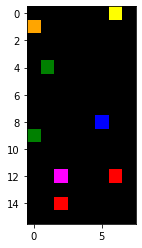

In [500]:
img = image_object_positions(positions=random_coordinates_n())
plt.imshow(img)

In [501]:
X = np.array([image_object_positions(positions=random_coordinates_n()) for _ in range(500000)])
h, w, c = X.shape[1:]

<IPython.core.display.Javascript object>

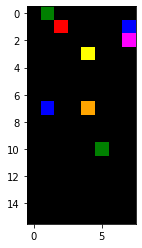

In [502]:
plt.imshow(X[0])

In [503]:
ae = tf.keras.Sequential([
    tf.keras.Input(shape=(h, w, c)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(h * w * c, activation='relu'),
    tf.keras.layers.Dense(4 * n_obj, activation=None),
    tf.keras.layers.Dense(10 * n_obj, activation='sigmoid'),
    tf.keras.layers.Dense(h * w * c, activation='sigmoid'),
    tf.keras.layers.Reshape((h, w, c))
])

In [504]:
ae.compile(tf.optimizers.Adam(lr=1e-4), 'mse')

In [ ]:
history = ae.fit(X, X, epochs=500090, verbose=0)

In [ ]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [ ]:
ae.evaluate(X, X)

In [ ]:
hid = tf.keras.models.Model(inputs=ae.inputs, outputs=ae.layers[1].output)

In [ ]:
idx = np.random.choice(len(X))

img = X[idx].reshape(h, w, c)
pred = ae.predict(X[idx:idx+1])[0].reshape(h, w, c)
# hidden = hid.predict(X[idx:idx+1])[0].reshape(2)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(pred)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(img - pred))
plt.show()

In [ ]:
@tf.function
def abs_max(y_true, y_pred):
    
    l = tf.abs(y_true - y_pred) ** 4
    l = tf.reduce_mean(l, axis=0)
    l = tf.reduce_sum(l)

    return l

In [ ]:
ae1 = tf.keras.Sequential([
    tf.keras.Input(shape=(h, w, c)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(h * w * c, activation='relu'),
    tf.keras.layers.Dense(4 * n_obj, activation=None),
    tf.keras.layers.Dense(10 * n_obj, activation='sigmoid'),
    tf.keras.layers.Dense(h * w * c, activation='sigmoid'),
    tf.keras.layers.Reshape((h, w, c))
])

In [ ]:
ae1.compile(tf.optimizers.Adam(lr=1e-3), abs_max)

In [ ]:
history = ae1.fit(X, X, epochs=5000, verbose=0)

In [ ]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [ ]:
ae1.evaluate(X, X)

In [ ]:
idx = np.random.choice(len(X))

img = X[idx].reshape(h, w, c)
pred = ae1.predict(X[idx:idx+1])[0].reshape(h, w, c)
# hidden = hid.predict(X[idx:idx+1])[0].reshape(2)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(pred)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(img - pred))
plt.show()

In [ ]:
plt.hist(np.abs((pred - img).flatten()))